In [30]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.mane_utils import *

In [10]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [11]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = '../../proc_revisions/ref/biomart_human_to_mouse.tsv'


mouse_ver = 'vM25_cerberus'

In [12]:
sns.set_context('paper', font_scale=1.8)
c_dict, order = get_biosample_colors()

In [13]:
ab_df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(ab_df,
               how='iso',
               min_tpm=min_tpm,
               gene_subset=gene_subset)
det_df = get_det_table(ab_df,
               how='iso',
               min_tpm=min_tpm,
               gene_subset=gene_subset)

Calculating iso TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 191325
Calculating iso TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 191325
Found 138 total libraries


In [14]:
# get all pairwise sets of tech reps
meta_df = pd.read_csv(lib_meta, sep='\t')
meta_df['biorep'] = meta_df['dataset'].str.rsplit('_', n=1, expand=True)[0]

all_pairs = []
for b in meta_df['biorep'].unique().tolist():
    b_datasets = meta_df.loc[meta_df.biorep==b, 'dataset'].tolist()
    pairs = list(itertools.combinations(b_datasets, 2))
    all_pairs += pairs

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1690: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


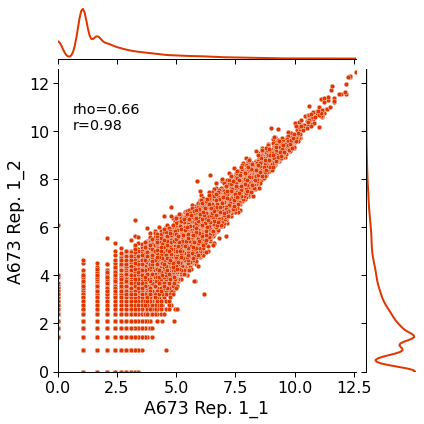

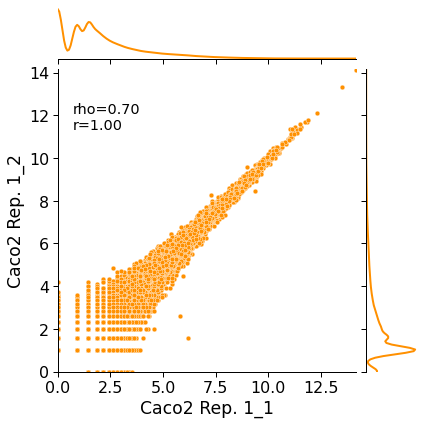

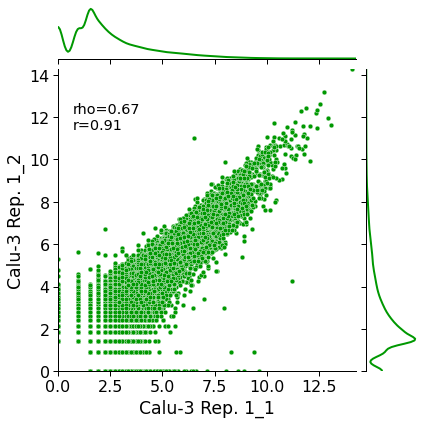

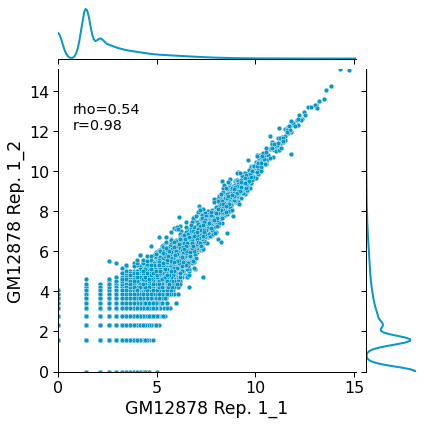

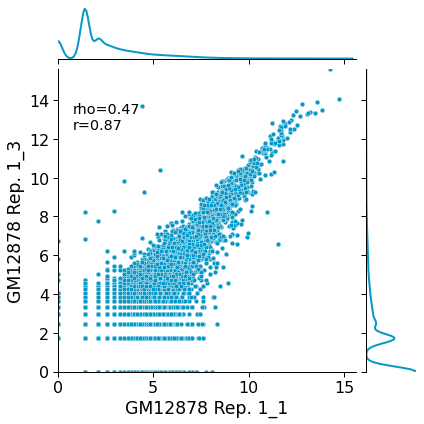

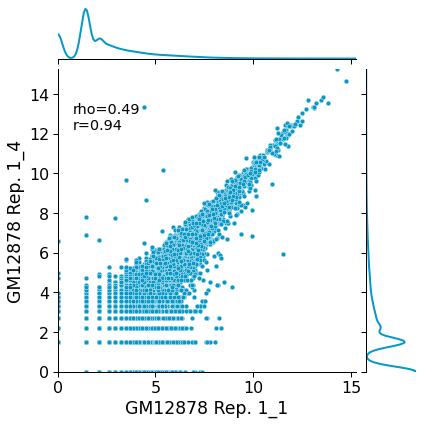

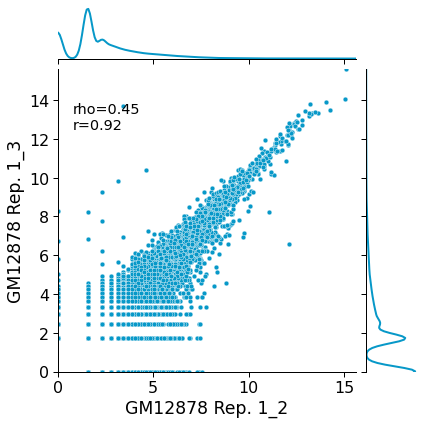

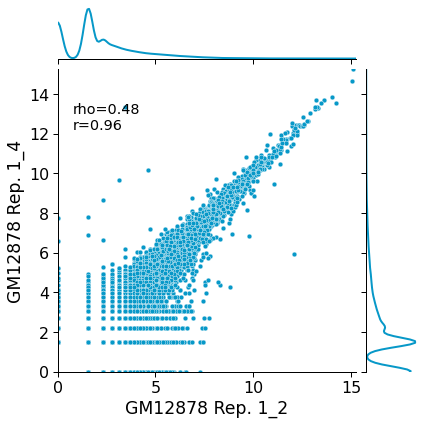

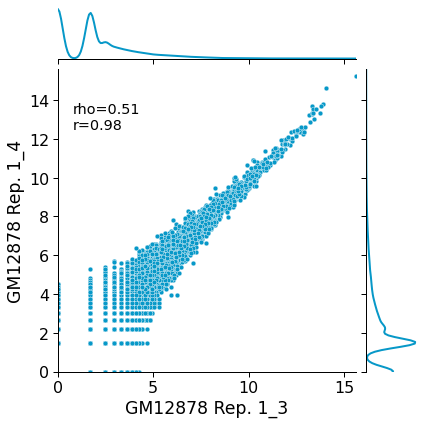

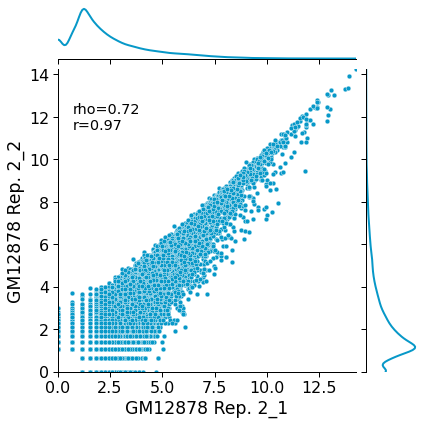

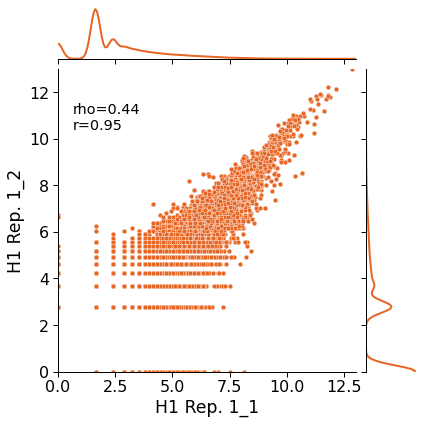

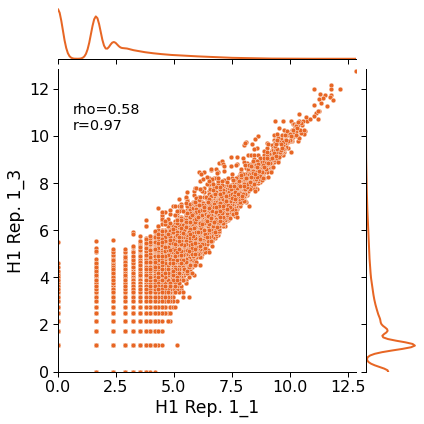

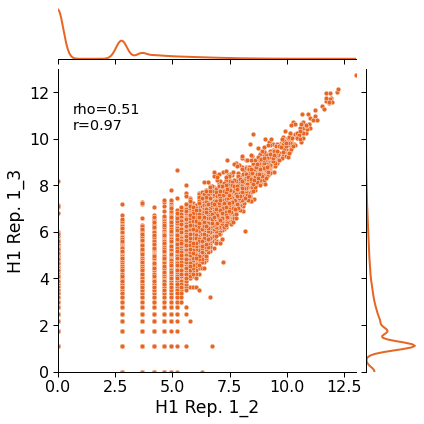

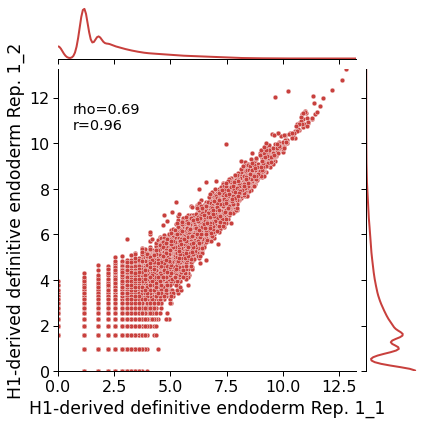

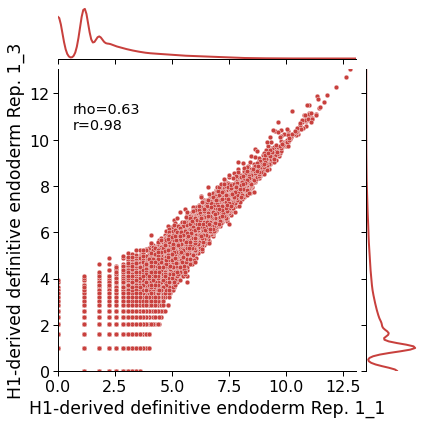

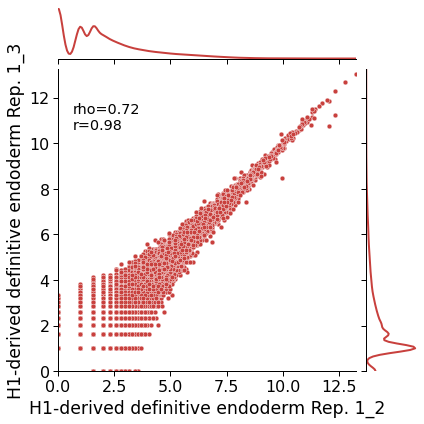

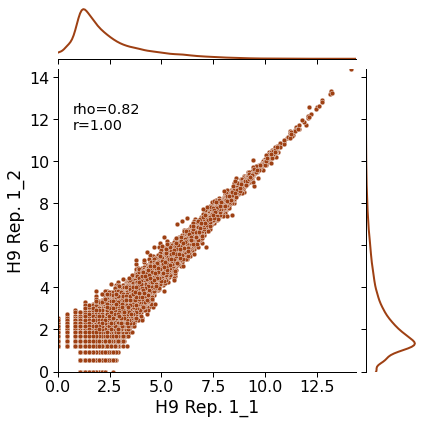

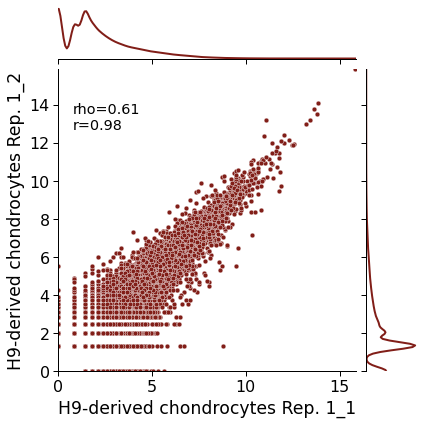

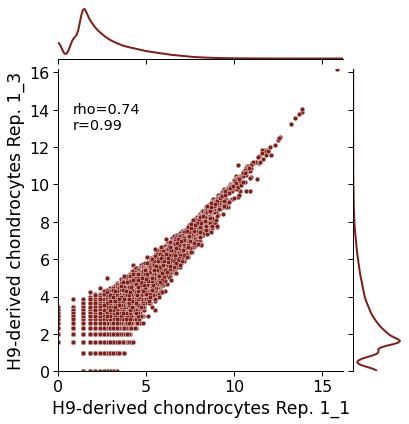

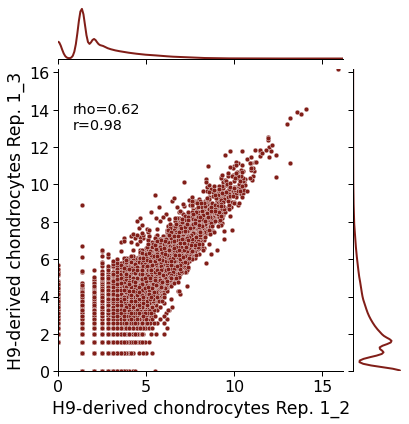

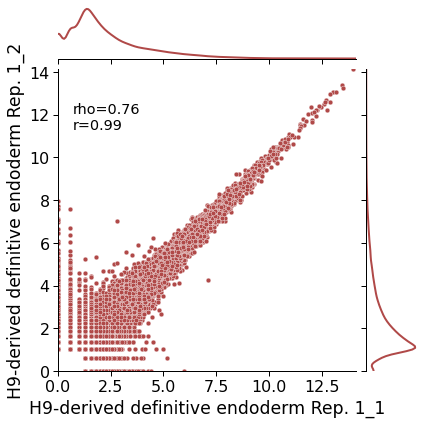

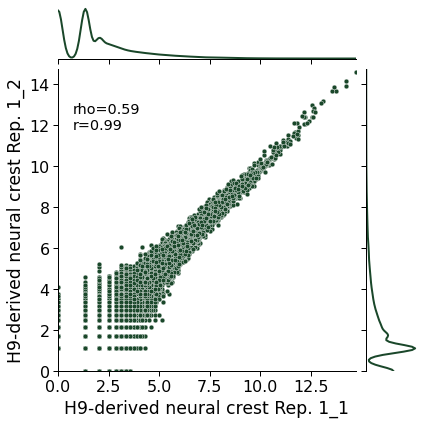

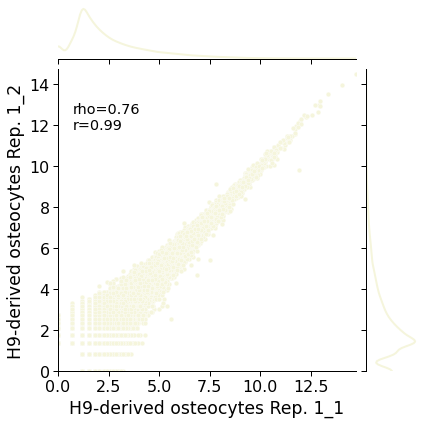

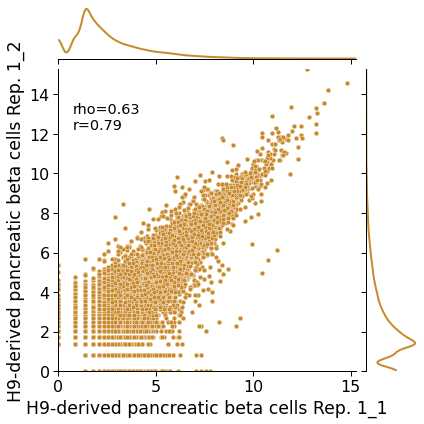

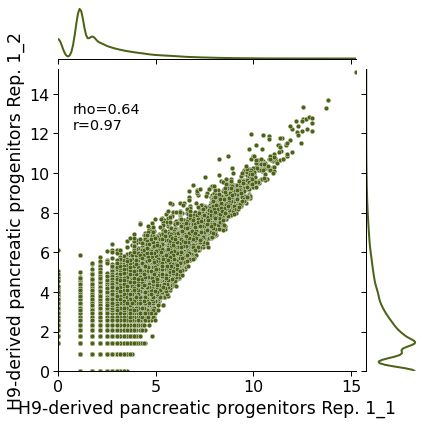

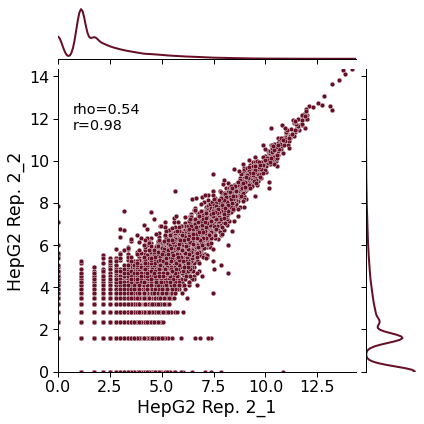

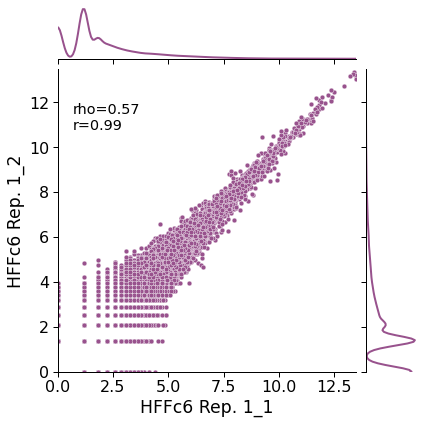

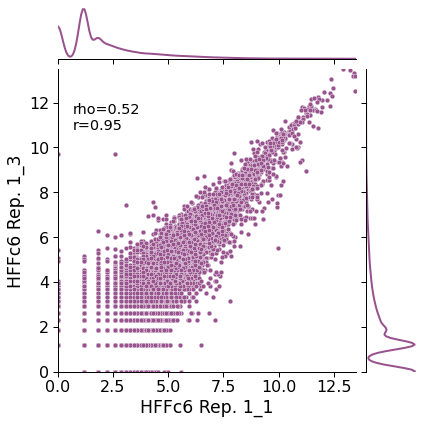

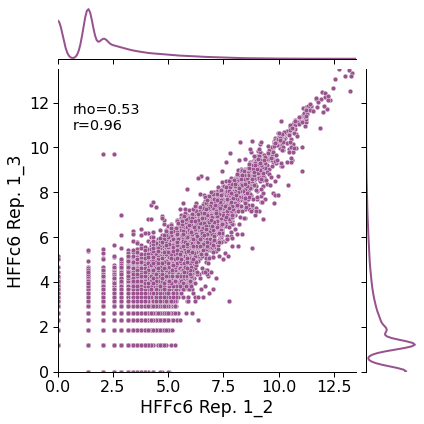

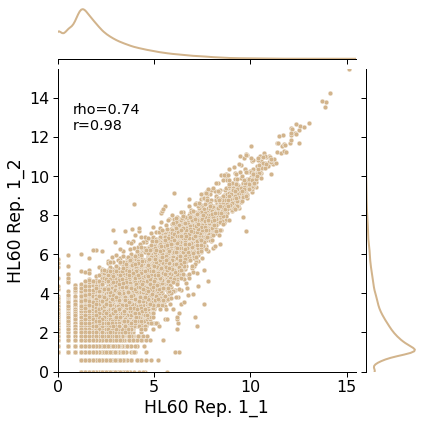

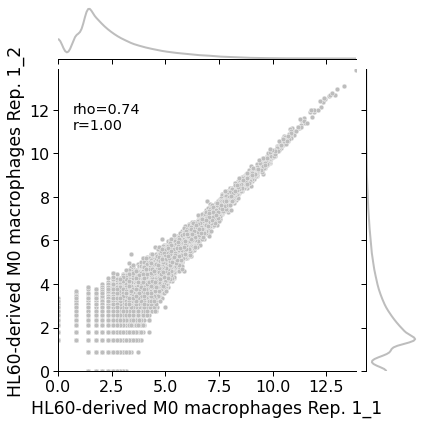

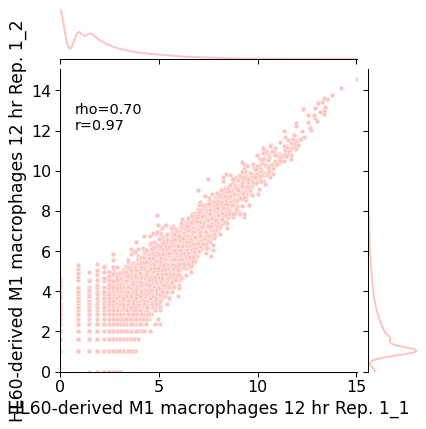

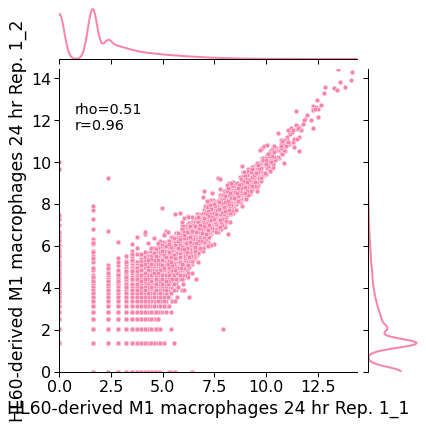

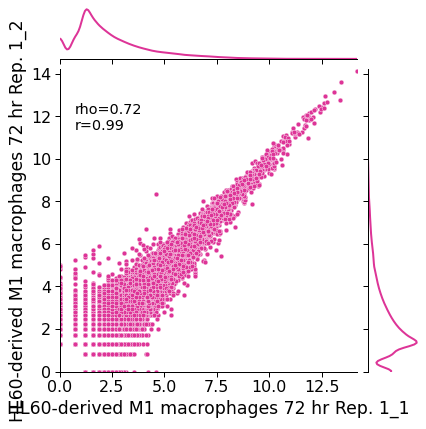

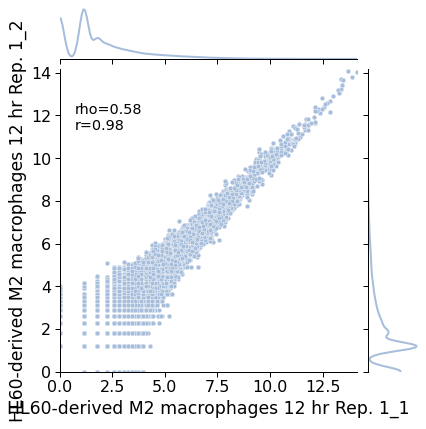

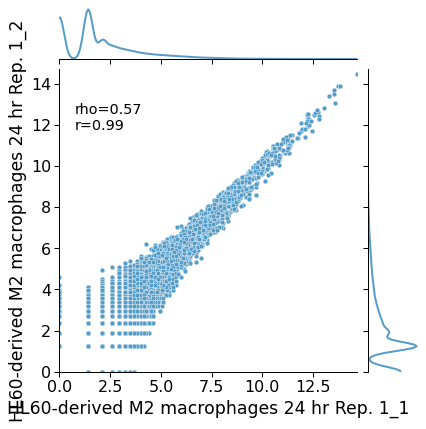

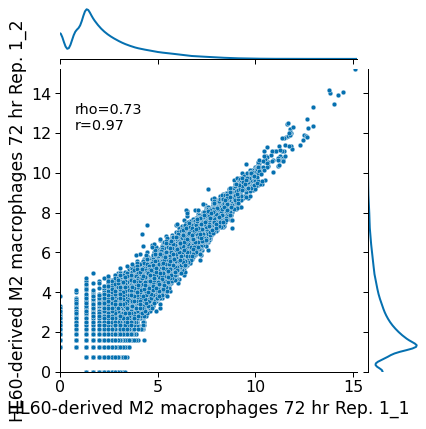

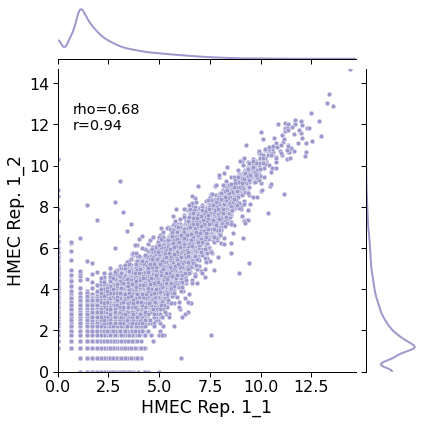

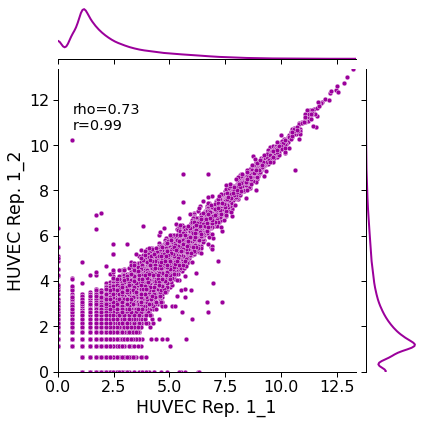

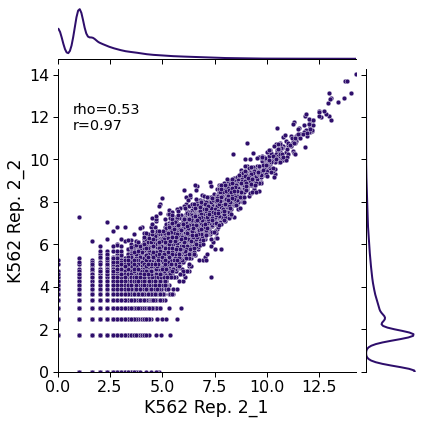

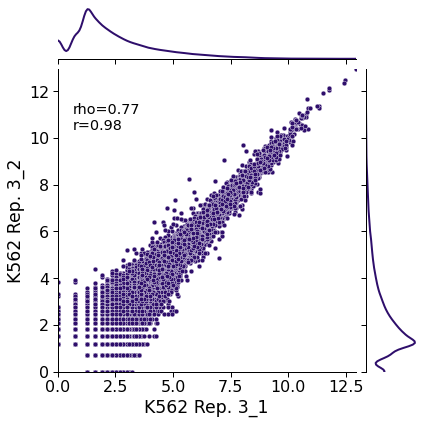

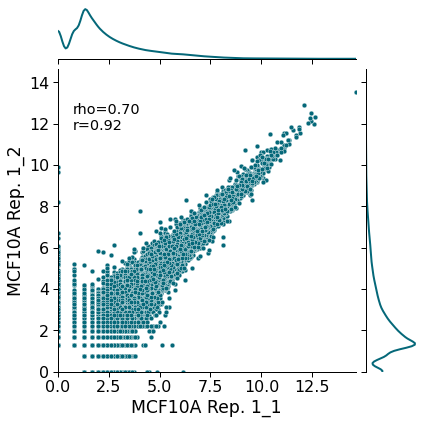

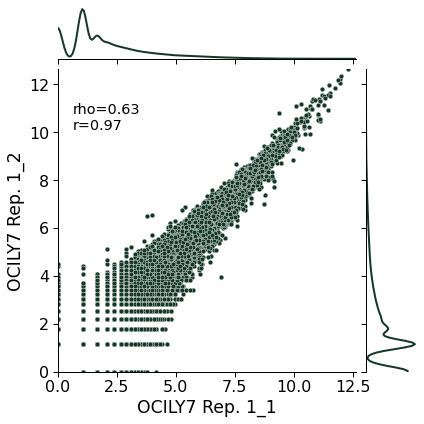

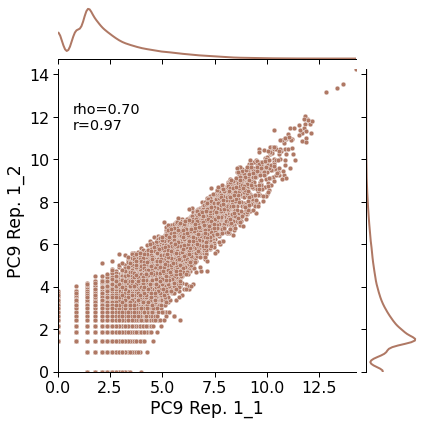

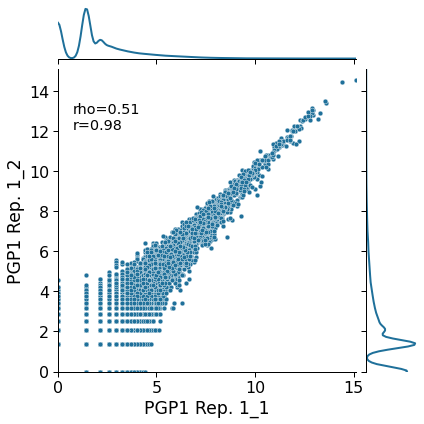

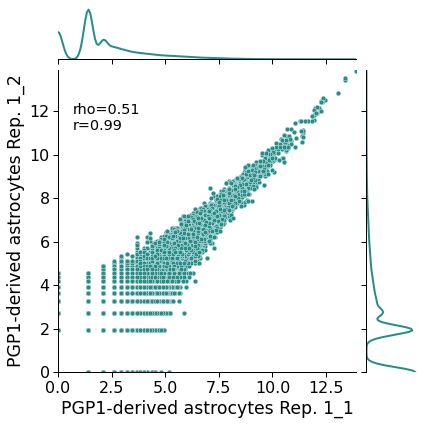

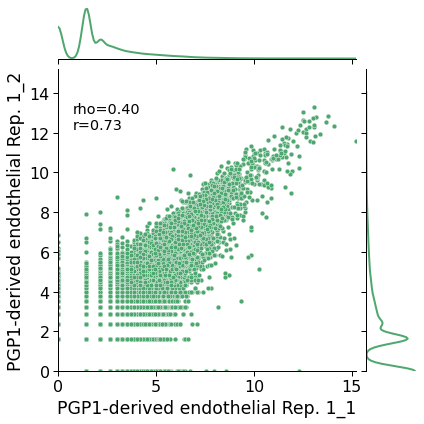

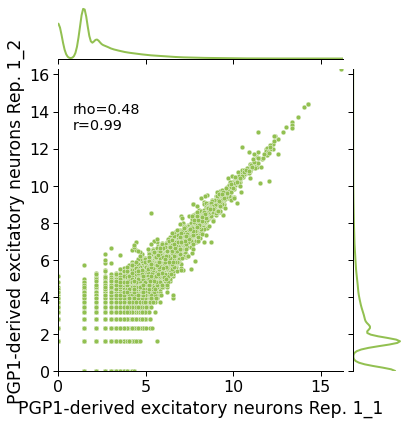

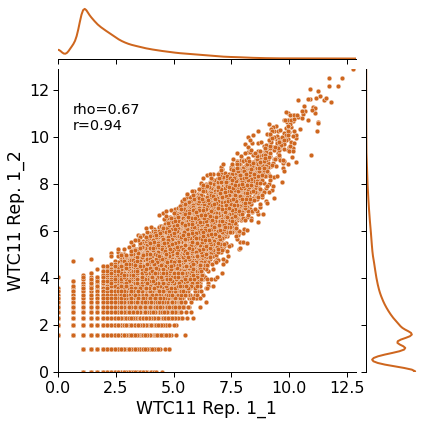

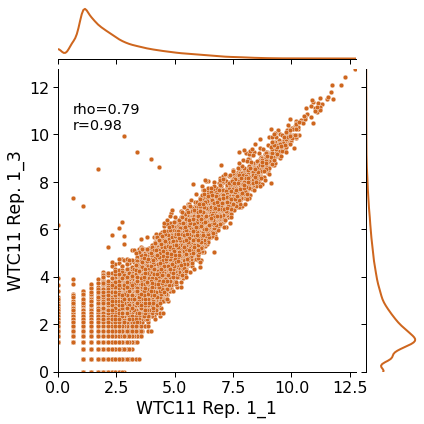

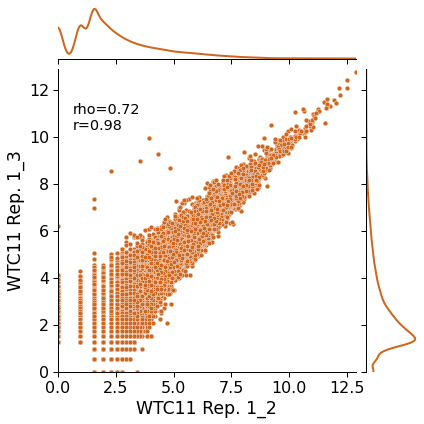

In [28]:
fnames = []
for i, p in enumerate(all_pairs):
    sample = p[0].rsplit('_', 2)[0]
    x = p[0]
    y = p[1]
    
    temp = df[[x, y]].copy(deep=True)
    # temp['sample'] = sample
    
    # remove transcripts expressed >1 TPM
    temp_det = det_df.transpose()[[x, y]].copy(deep=True)
    det_tids = temp_det.loc[temp_det.any(axis=1)].index.tolist()
    temp = temp.loc[det_tids]

    rho, p = st.spearmanr(temp[x].tolist(), temp[y].tolist())
    r, p2 = st.pearsonr(temp[x].tolist(), temp[y].tolist())
    
    # add pseudocounts and plot log2tpm
    temp = temp+1
    temp = np.log2(temp)
    lim = (0, max(temp[x].max(), temp[y].max()))
    
    g = sns.JointGrid(data=temp, x=x, y=y, ylim=lim, xlim=lim)
    g.plot_joint(sns.scatterplot, color=c_dict[sample])
    g.plot_marginals(sns.kdeplot, color=c_dict[sample], linewidth=2)
    
    # g.plot_marginals(sns.distplot, kde=True)
    # g = sns.jointplot(temp, x=x, y=y, color=c_dict[sample],
    #                   ylim=lim, xlim=lim, kind='kde', marginal_kws={'linewidth':2}) 
    for d, ax in zip([x,y], ['x','y']):
        label = meta_df.loc[meta_df.dataset==d, 'sample_display'].values[0]
        label += f" Rep. {'_'.join(d.rsplit('_',2)[-2:])}"
        if ax == 'x':
            g.ax_joint.set_xlabel(label)
        elif ax == 'y':
            g.ax_joint.set_ylabel(label)
    plt.text(.05, .8, 'rho={:.2f}\nr={:.2f}'.format(rho,r), transform=g.ax_joint.transAxes,
              size='x-large')
    fname = f'figures/biorep_transcript_corr_{x}_{y}.png'
    plt.savefig(fname)
    fnames.append(fname)
    # plt.show()
    # plt.close(g)

In [33]:
import matplotlib.image as mpimg

51


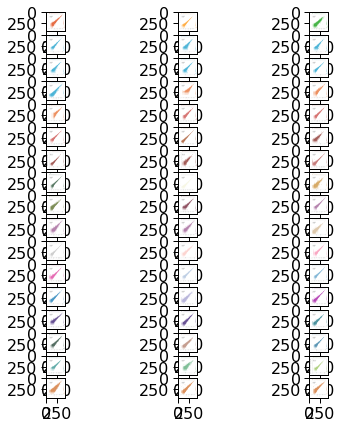

In [38]:
mm = 0.0393701  # mm in inches
f, axarr = plt.subplots(17, 3, squeeze=True, figsize=(180*mm, 180*mm))
axs = []
for i in range(axarr.shape[0]):
    for j in range(axarr.shape[1]):
        axs.append(axarr[i][j])
print(len(axs))
for i, f in enumerate(fnames):
    axs[i].imshow(mpimg.imread(f))
# plt.show()
plt.savefig('figures/maybe.pdf')